# Coursera Capstone Project

# Battle of the Neighbourhoods

## Introduction

With about 8.5 million people calling the city home, NYC remains one of the fastest growing cities in the world. Its demographics include a variety of diverse cultures & cuisines. This essentially means that whatever type of food you love, there is still hope for you in NYC.

## Business Problem

This report will try to analyse the data publicly available for NYC & try to answer the following questions:
*	Which parts of NYC have the most Japanese restaurants?
*	Which is the best location in NYC for Japanese cuisine?
*	Which areas have a dearth of Japanese restaurants?
*	What would be the best place to stay in NYC if you’re in love with sushi?
This analysis will help fellow sushi lovers to find their favourite place in the great city of New York. It might also help any individual(s) or companies looking to open a Japanese restaurant in the city.

## Dataset

The following datasets will be used for this analysis:
*	NYC location dataset
 +	Source: https://cocl.us/new_york_dataset
 +	Dataset includes names of neighbourhoods, boroughs & their respective location coordinates.
*	Japanese restaurants location & info
 +	Source: Foursquare API
 +	The API will be used to search for Japanese restaurants in NYC’s neighbourhoods.
*	Boundary Data
 +	Source: : https://data.cityofnewyork.us/City-Government/BoroughBoundaries/tqmj-j8zm
 +	This boundary data for the boroughs will help us plot the choropleth map of NYC.


## Methodology

* First, we will collect data from the NYC dataset and visualize the Japanese restaurants available in the neighbourhoods.
* After filtering out just the Japanese restaurants data (using the Foursquare API), we will aggregate them according to the boroughs & neighbourhoods they are in.
* We will create visualizations (borough-wise & neighbourhood-wise)
* We will also create a choropleth map, visualizing the number of Japanese restaurants.

## Analysis

Importing the necessary libraries.

In [3]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import geocoder
import os
import folium
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
%matplotlib inline

In [4]:
# Function to get latitude & longitude of a location
def geo_location(address):
    
    geolocator = Nominatim(user_agent="nyc_coursera")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [5]:
# Function to get top 100 venues within a 1km radius
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = --- # your Foursquare ID
    CLIENT_SECRET = --- # your Foursquare Secret
    VERSION = '20200401' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [46]:
# Function to get details for a particular venue
def get_venue_details(venue_id):
        
    CLIENT_ID = '---' # your Foursquare ID
    CLIENT_SECRET = '---' # your Foursquare Secret
    VERSION = '20200401' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Fetching the NYC data

In [7]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [8]:
new_york_data=get_new_york_data()
new_york_data.sample(5)

,Borough,Neighborhood,Latitude,Longitude
72,Brooklyn,East New York,40.669926,-73.880699
95,Brooklyn,East Williamsburg,40.708492,-73.938858
198,Staten Island,New Brighton,40.640615,-74.087017
139,Queens,Long Island City,40.750217,-73.939202
21,Bronx,Mott Haven,40.806239,-73.916100


In [10]:
print(f"Dataset has {new_york_data.shape[0]} neighbourhoods.")

Dataset has 306 neighbourhoods.


Next up, collecting all the Japanese restaurants from each neighborhood.

In [12]:
# prepare neighborhood list that contains japanese resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
japanese_rst_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    japanese_resturants=venues[venues['Category']=='Japanese Restaurant']   
    print('(',count,'/',len(new_york_data),')','Japanese Resturants in '+Neighborhood+', '+Borough+':'+str(len(japanese_resturants)))
    for resturant_detail in japanese_resturants.values.tolist():
        id, name , category=resturant_detail
        japanese_rst_ny = japanese_rst_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Japanese Resturants in Wakefield, Bronx:0
( 2 / 306 ) Japanese Resturants in Co-op City, Bronx:0
( 3 / 306 ) Japanese Resturants in Eastchester, Bronx:0
( 4 / 306 ) Japanese Resturants in Fieldston, Bronx:0
( 5 / 306 ) Japanese Resturants in Riverdale, Bronx:2
( 6 / 306 ) Japanese Resturants in Kingsbridge, Bronx:2
( 7 / 306 ) Japanese Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Japanese Resturants in Woodlawn, Bronx:0
( 9 / 306 ) Japanese Resturants in Norwood, Bronx:0
( 10 / 306 ) Japanese Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Japanese Resturants in Baychester, Bronx:0
( 12 / 306 ) Japanese Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Japanese Resturants in City Island, Bronx:1
( 14 / 306 ) Japanese Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Japanese Resturants in University Heights, Bronx:0
( 16 / 306 ) Japanese Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Japanese Resturants in Fordham, Bronx:0
( 18 / 306 ) Japanese Resturants in Ea

( 138 / 306 ) Japanese Resturants in Richmond Hill, Queens:0
( 139 / 306 ) Japanese Resturants in Flushing, Queens:1
( 140 / 306 ) Japanese Resturants in Long Island City, Queens:1
( 141 / 306 ) Japanese Resturants in Sunnyside, Queens:0
( 142 / 306 ) Japanese Resturants in East Elmhurst, Queens:0
( 143 / 306 ) Japanese Resturants in Maspeth, Queens:1
( 144 / 306 ) Japanese Resturants in Ridgewood, Queens:0
( 145 / 306 ) Japanese Resturants in Glendale, Queens:1
( 146 / 306 ) Japanese Resturants in Rego Park, Queens:1
( 147 / 306 ) Japanese Resturants in Woodhaven, Queens:0
( 148 / 306 ) Japanese Resturants in Ozone Park, Queens:0
( 149 / 306 ) Japanese Resturants in South Ozone Park, Queens:0
( 150 / 306 ) Japanese Resturants in College Point, Queens:1
( 151 / 306 ) Japanese Resturants in Whitestone, Queens:2
( 152 / 306 ) Japanese Resturants in Bayside, Queens:0
( 153 / 306 ) Japanese Resturants in Auburndale, Queens:1
( 154 / 306 ) Japanese Resturants in Little Neck, Queens:1
( 155 

( 271 / 306 ) Japanese Resturants in Mount Hope, Bronx:0
( 272 / 306 ) Japanese Resturants in Sutton Place, Manhattan:0
( 273 / 306 ) Japanese Resturants in Hunters Point, Queens:3
( 274 / 306 ) Japanese Resturants in Turtle Bay, Manhattan:1
( 275 / 306 ) Japanese Resturants in Tudor City, Manhattan:2
( 276 / 306 ) Japanese Resturants in Stuyvesant Town, Manhattan:1
( 277 / 306 ) Japanese Resturants in Flatiron, Manhattan:3
( 278 / 306 ) Japanese Resturants in Sunnyside Gardens, Queens:0
( 279 / 306 ) Japanese Resturants in Blissville, Queens:0
( 280 / 306 ) Japanese Resturants in Fulton Ferry, Brooklyn:1
( 281 / 306 ) Japanese Resturants in Vinegar Hill, Brooklyn:0
( 282 / 306 ) Japanese Resturants in Weeksville, Brooklyn:0
( 283 / 306 ) Japanese Resturants in Broadway Junction, Brooklyn:0
( 284 / 306 ) Japanese Resturants in Dumbo, Brooklyn:1
( 285 / 306 ) Japanese Resturants in Manor Heights, Staten Island:0
( 286 / 306 ) Japanese Resturants in Willowbrook, Staten Island:0
( 287 / 3

Now that we have filtered out all the Japanese restaurants in NYC, lets start our analysis.

In [18]:
# Getting a taste of the data
japanese_rst_ny.sample(5)

,Borough,Neighborhood,ID,Name
92,Queens,Long Island City,5a22f5b8d41bb773bfc3f5c3,Suzuki Shokudo
8,Bronx,Castle Hill,54e0efc3498e7eda5dff1847,Sarku
151,Queens,Utopia,4d7926de930ef04da310c24f,Tokyo Hibachi Steak House & Sushi
38,Brooklyn,Bath Beach,513e7ec8e4b07f4fa1b53b3d,Fuki Sushi Japanese Restaurant
13,Brooklyn,Bensonhurst,4c326b9fa0ced13ac126156e,Ichi Sushi


In [20]:
print(f"Found {japanese_rst_ny.shape[0]} Japanese restaurants in NYC.")

Found 171 Japanese restaurants in NYC.


Lets count the Japanese restaurants borough-wise.

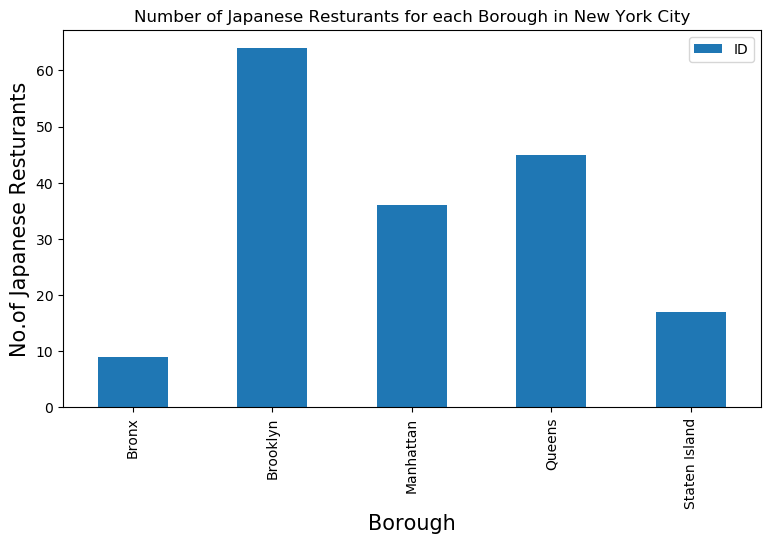

In [22]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Japanese Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Japanese Resturants', fontsize=15)
#giving a bar plot
japanese_rst_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Looks like Brooklyn has the most Japanese restaurants in NYC, followed by Queens & then the Manhattan Island.

Lets do the same & list out the top 10 Neighbourhoods.

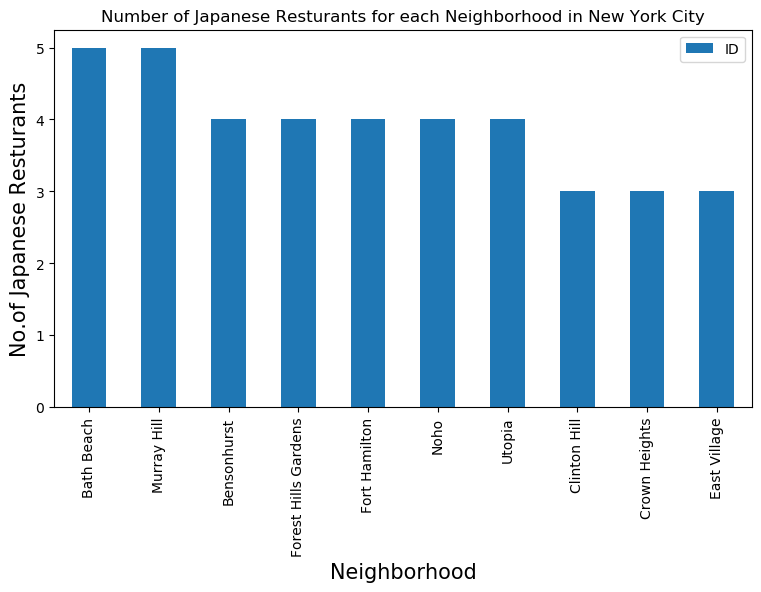

In [69]:

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Japanese Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Japanese Resturants', fontsize=15)
#giving a bar plot
japanese_rst_ny.groupby('Neighborhood')['ID'].count().nlargest(10).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Looks like the Bath Beach neighborhood & the Murray Hill neighborhood tie out for the first place at 5 Japanese restaurants each.

Now that we have the number of Japanese restaurants in each Borough, lets visualize the same using a choropleth map.

In [59]:
japanese_boro_data = pd.DataFrame(japanese_rst_ny.groupby('Borough')['ID'].count())
japanese_boro_data.reset_index(level = 0, inplace = True)
japanese_boro_data.head()

,Borough,ID
0,Bronx,9
1,Brooklyn,64
2,Manhattan,36
3,Queens,45
4,Staten Island,17


In [64]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = r'Borough Boundaries.geojson'

map = ny_map.choropleth(
    geo_data=ny_geo,
    data=japanese_boro_data,
    columns=['Borough', 'ID'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Number of Japanese Restaurants'
)

# as this is huge map data , we will save it to a file
ny_map.save('borough_count.html')